In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx


In [2]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------


# Define base directory and processed/raw paths
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Load LSOA with 2SFCA baseline scores
gdf_lsoa = gpd.read_file(os.path.join(processed_dir, "LSOA_CT_2SFCA_Accessibility_2024.gpkg"))

# Load scanner site supply GeoDataFrame
gdf_sites = gpd.read_file(os.path.join(processed_dir, "CT_Scanner_Sites_With_SupplyRatios.gpkg"))

# Load travel matrix (used unchanged from raw)
df_travel = pd.read_csv(os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv"))

print("Baseline data loaded. Ready to define scenario.")


Baseline data loaded. Ready to define scenario.


In [19]:
# ----------------------------------------------------------
# Step 2 – Suggest High-Impact LSOAs for New Scanner Sites
# ----------------------------------------------------------

from shapely.geometry import Point
from sklearn.preprocessing import minmax_scale

# 2.1 – Mean accessibility across modes
gdf_lsoa['accessibility_score_mean'] = gdf_lsoa[[
    'accessibility_score_car',
    'accessibility_score_pt_peak',
    'accessibility_score_pt_nonpeak'
]].mean(axis=1)

# 2.1a – Rescale accessibility to [0, 1] (avoids tiny numbers)
gdf_lsoa['access_scaled'] = minmax_scale(
    gdf_lsoa['accessibility_score_mean'].fillna(0)
)

# 2.2 – Identify LSOAs already served (<20 min to CT site)
reachable_lsoas = df_travel[
    (df_travel['travel_time_car'] <= 20) &
    (df_travel['destination_name'].isin(gdf_sites['lsoa21cd']))
]['origin_name'].unique()

gdf_lsoa['already_served'] = gdf_lsoa['lsoa21cd'].isin(reachable_lsoas)

# 2.3 – Filter to unserved, low-access, nonzero-demand
gdf_candidates = gdf_lsoa[
    (gdf_lsoa['already_served'] == False) &
    (gdf_lsoa['access_scaled'] <= gdf_lsoa['access_scaled'].quantile(0.3)) &
    (gdf_lsoa['ct_total_demand'] > 0)
].copy()

# 2.4 – Calculate impact score = unmet access × demand
gdf_candidates['impact_score'] = (
    (1 - gdf_candidates['access_scaled']) * gdf_candidates['ct_total_demand']
)

# 2.5 – Rank and select top 5
gdf_scenario_sites = (
    gdf_candidates.sort_values('impact_score', ascending=False)
    .head(5)
    .copy()
)

# 2.6 – Add site metadata
gdf_scenario_sites['site_id'] = ['SCENARIO_' + str(i+1) for i in range(len(gdf_scenario_sites))]
gdf_scenario_sites['site_name'] = 'Proposed Site'
gdf_scenario_sites['ct_scanners'] = 1
gdf_scenario_sites['site_type'] = 'Scenario'
gdf_scenario_sites['geometry'] = gdf_scenario_sites.centroid

# 2.7 – Finalise format
site_cols = ['site_id', 'site_name', 'ct_scanners', 'lsoa21cd', 'site_type', 'geometry']
gdf_new_sites = gpd.GeoDataFrame(gdf_scenario_sites[site_cols], crs=gdf_lsoa.crs)

# 2.8 – Preview
print("Top candidate LSOAs selected for scenario testing:")
display(gdf_new_sites[['site_id', 'lsoa21cd', 'ct_scanners']])


Top candidate LSOAs selected for scenario testing:


,site_id,lsoa21cd,ct_scanners
2598,SCENARIO_1,E01019957,1
2618,SCENARIO_2,E01019961,1
2609,SCENARIO_3,E01019947,1
2961,SCENARIO_4,E01034858,1
2674,SCENARIO_5,E01020138,1


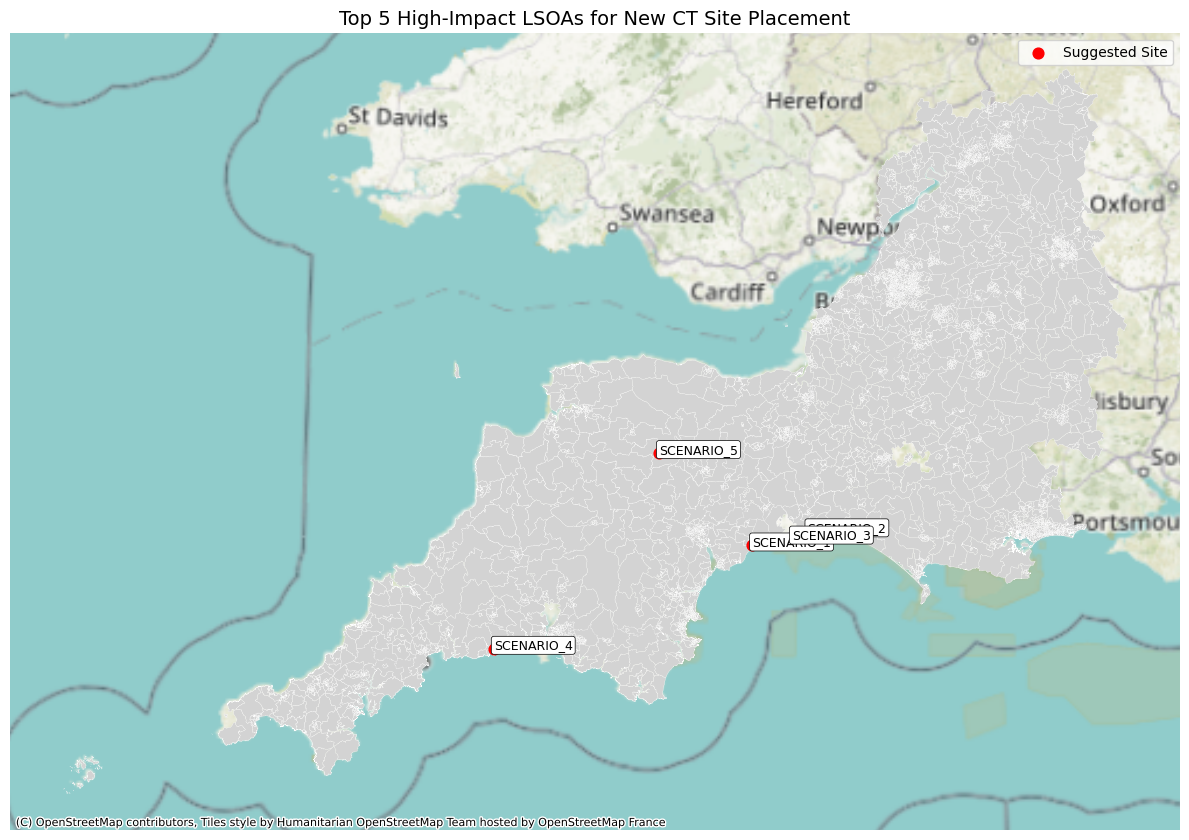

In [20]:
# ----------------------------------------------------------
# Step 2a – Visualise Suggested LSOAs with Arrows
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import contextily as ctx

# Plot base layer: all LSOAs
fig, ax = plt.subplots(figsize=(12, 12))
gdf_lsoa.plot(ax=ax, color='lightgrey', linewidth=0.2, edgecolor='white')

# Highlight suggested scenario sites
gdf_new_sites.plot(ax=ax, color='red', markersize=60, label='Suggested Site')

# Draw arrows pointing to each candidate LSOA
for _, row in gdf_new_sites.iterrows():
    x, y = row.geometry.x, row.geometry.y
    ax.annotate(
        row['site_id'],
        xy=(x, y),
        xytext=(x + 0.1, y + 0.1),  # offset label
        textcoords='data',
        arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1),
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.5)
    )

# Add basemap
ctx.add_basemap(ax, crs=gdf_lsoa.crs.to_string())
ax.set_title("Top 5 High-Impact LSOAs for New CT Site Placement", fontsize=14)
ax.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# ----------------------------------------------------------
# Step 2b – Inspect Impact Scores for Candidate LSOAs (Rescaled)
# ----------------------------------------------------------

# Use rescaled access score in display
gdf_scenario_sites = (
    gdf_scenario_sites.sort_values("impact_score", ascending=False)
    .reset_index(drop=True)
    .assign(impact_rank=lambda df: df.index + 1)
)

inspect_cols = [
    "impact_rank",
    "site_id",
    "lsoa21cd",
    "access_scaled",           # show rescaled score
    "ct_total_demand",
    "impact_score"
]

print("Impact ranking of the top‑five candidate LSOAs (rescaled access):\n")
display(
    gdf_scenario_sites[inspect_cols].style.format({
        "access_scaled": "{:.3f}",
        "ct_total_demand": "{:,.0f}",
        "impact_score": "{:,.0f}"
    })
)


Impact ranking of the top‑five candidate LSOAs (rescaled access):



,impact_rank,site_id,lsoa21cd,access_scaled,ct_total_demand,impact_score
0,1,SCENARIO_1,E01019957,0.119,450,396
1,2,SCENARIO_2,E01019961,0.000,385,385
2,3,SCENARIO_3,E01019947,0.000,373,373
3,4,SCENARIO_4,E01034858,0.000,366,366
4,5,SCENARIO_5,E01020138,0.000,362,362


In [23]:
# ----------------------------------------------------------
# Step 3 – Append SCENARIO_1, SCENARIO_4 and SCENARIO_5 (CRS‑Aligned)
# ----------------------------------------------------------

# 3.1 – Keep only Scenario 1, 4, and 5
scenario_test_sites = gdf_scenario_sites[
    gdf_scenario_sites["site_id"].isin(["SCENARIO_1", "SCENARIO_4", "SCENARIO_5"])
].copy()

# 3.2 – Re‑project scenario sites to match gdf_sites CRS (EPSG 4326)
scenario_test_sites = scenario_test_sites.to_crs(gdf_sites.crs)

# 3.3 – Concatenate into a single supply GeoDataFrame
gdf_sites_scenario = pd.concat([gdf_sites, scenario_test_sites], ignore_index=True)
gdf_sites_scenario = gpd.GeoDataFrame(gdf_sites_scenario, geometry="geometry", crs=gdf_sites.crs)

# 3.4 – Preview result
print("CT supply with SCENARIO_1, SCENARIO_4 and SCENARIO_5 added:")
display(
    gdf_sites_scenario[["site_id", "site_type", "lsoa21cd", "ct_scanners"]].tail(10)
)


CT supply with SCENARIO_1, SCENARIO_4 and SCENARIO_5 added:


,site_id,site_type,lsoa21cd,ct_scanners
29,R0D01,Acute,E01034281,3
30,R0D02,Acute,E01015319,3
31,RHM25,Acute,E01032643,2
32,RVJ01,Acute,E01014632,5
33,REF12,Acute,E01034862,3
34,RWV12,Acute,E01020134,2
35,RH8D2,Acute,E01015092,5
36,SCENARIO_1,Scenario,E01019957,1
37,SCENARIO_4,Scenario,E01034858,1
38,SCENARIO_5,Scenario,E01020138,1


In [26]:
# A. Keep only essential columns in gdf_sites_scenario
supply_cols = ['site_id', 'site_name', 'ct_scanners', 'lsoa21cd', 'site_type', 'geometry']
gdf_sites_scenario = gdf_sites_scenario[supply_cols].copy()

# B. Ensure baseline band columns exist in gdf_lsoa
for col in ["ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]:
    if col not in gdf_lsoa.columns:
        gdf_lsoa[col] = 0  # treat as zero baseline

# Remove duplicate _x/_y columns if desired
dup_cols = [c for c in gdf_lsoa.columns if c.endswith(('_x', '_y'))]
gdf_lsoa = gdf_lsoa.drop(columns=dup_cols)

print("Columns cleaned. Re‑run the patched Step 4 code.")


Columns cleaned. Re‑run the patched Step 4 code.


In [30]:
# ----------------------------------------------------------
# Step 4 – Recalculate Accessibility with Scenario Supply (Robust)
# (now using SCENARIO_1, SCENARIO_4, and SCENARIO_5)
# ----------------------------------------------------------

# --- Preliminaries: string‑clean LSOA codes ---
for df in (df_travel, gdf_sites_scenario, gdf_lsoa):
    for col in ("origin_name", "destination_name", "lsoa21cd"):
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

# --- Restrict travel matrix to destinations that are CT sites ---
dest_lsoas = gdf_sites_scenario["lsoa21cd"].unique()
df_travel_supply = df_travel[df_travel["destination_name"].isin(dest_lsoas)].copy()

# --- Attach scanner counts to each destination row ---
df_travel_supply = df_travel_supply.merge(
    gdf_sites_scenario[["lsoa21cd", "ct_scanners"]].rename(columns={"lsoa21cd": "destination_name"}),
    on="destination_name",
    how="left"
)

# --- Define travel‑time bands we want ---
time_bands = [
    ("ct_access_car_lt_20",  0, 20),   # < 20 min
    ("ct_access_car_20_40", 20, 40),   # 20–40 min
    ("ct_access_car_gt_40", 40, None)  # > 40 min
]

# --- Aggregate scanners per origin for each band ---
band_frames = []
for col_name, lo, hi in time_bands:
    if hi is None:
        mask = df_travel_supply["travel_time_car"] > lo
    else:
        mask = (df_travel_supply["travel_time_car"] >= lo) & (df_travel_supply["travel_time_car"] < hi)

    series = (
        df_travel_supply[mask]
        .groupby("origin_name")["ct_scanners"]
        .sum()
        .rename(col_name)
    )
    band_frames.append(series)

# --- Concatenate results and fill missing origins with 0 ---
df_access_new = (
    pd.concat(band_frames, axis=1)
    .fillna(0)
    .reset_index()
    .rename(columns={"origin_name": "lsoa21cd"})
)

# --- Merge new accessibility scores and compute deltas robustly ---
for col, _, _ in time_bands:
    new_col   = col + "_scenario"
    delta_col = col + "_delta"

    # Skip if base column is missing from df_access_new
    if col not in df_access_new.columns:
        print(f"[Warning] Column '{col}' missing in df_access_new – skipping.")
        continue

    # Prepare new version
    df_tmp = df_access_new[["lsoa21cd", col]].rename(columns={col: new_col})

    # Drop the column from gdf_lsoa if it already exists (from a previous run)
    if new_col in gdf_lsoa.columns:
        gdf_lsoa = gdf_lsoa.drop(columns=new_col)

    # Do the merge
    gdf_lsoa = gdf_lsoa.merge(df_tmp, on="lsoa21cd", how="left")

    # Fill NaN (no reachable scanners) with 0
    gdf_lsoa[new_col] = gdf_lsoa[new_col].fillna(0)

    # Compute delta vs. baseline
    if col in gdf_lsoa.columns:
        gdf_lsoa[delta_col] = gdf_lsoa[new_col] - gdf_lsoa[col]
    else:
        gdf_lsoa[delta_col] = gdf_lsoa[new_col]


# --- Quick check of average improvement ---
print("\nMean change in number of CT scanners reachable:")
print(gdf_lsoa[[c for c in gdf_lsoa.columns if c.endswith("_delta")]].mean().round(2))



Mean change in number of CT scanners reachable:
ct_access_car_lt_20_new_delta     0.00
ct_access_car_lt_20_delta         1.99
ct_access_car_20_40_delta         3.41
ct_access_car_gt_40_delta        56.47
dtype: float64


/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


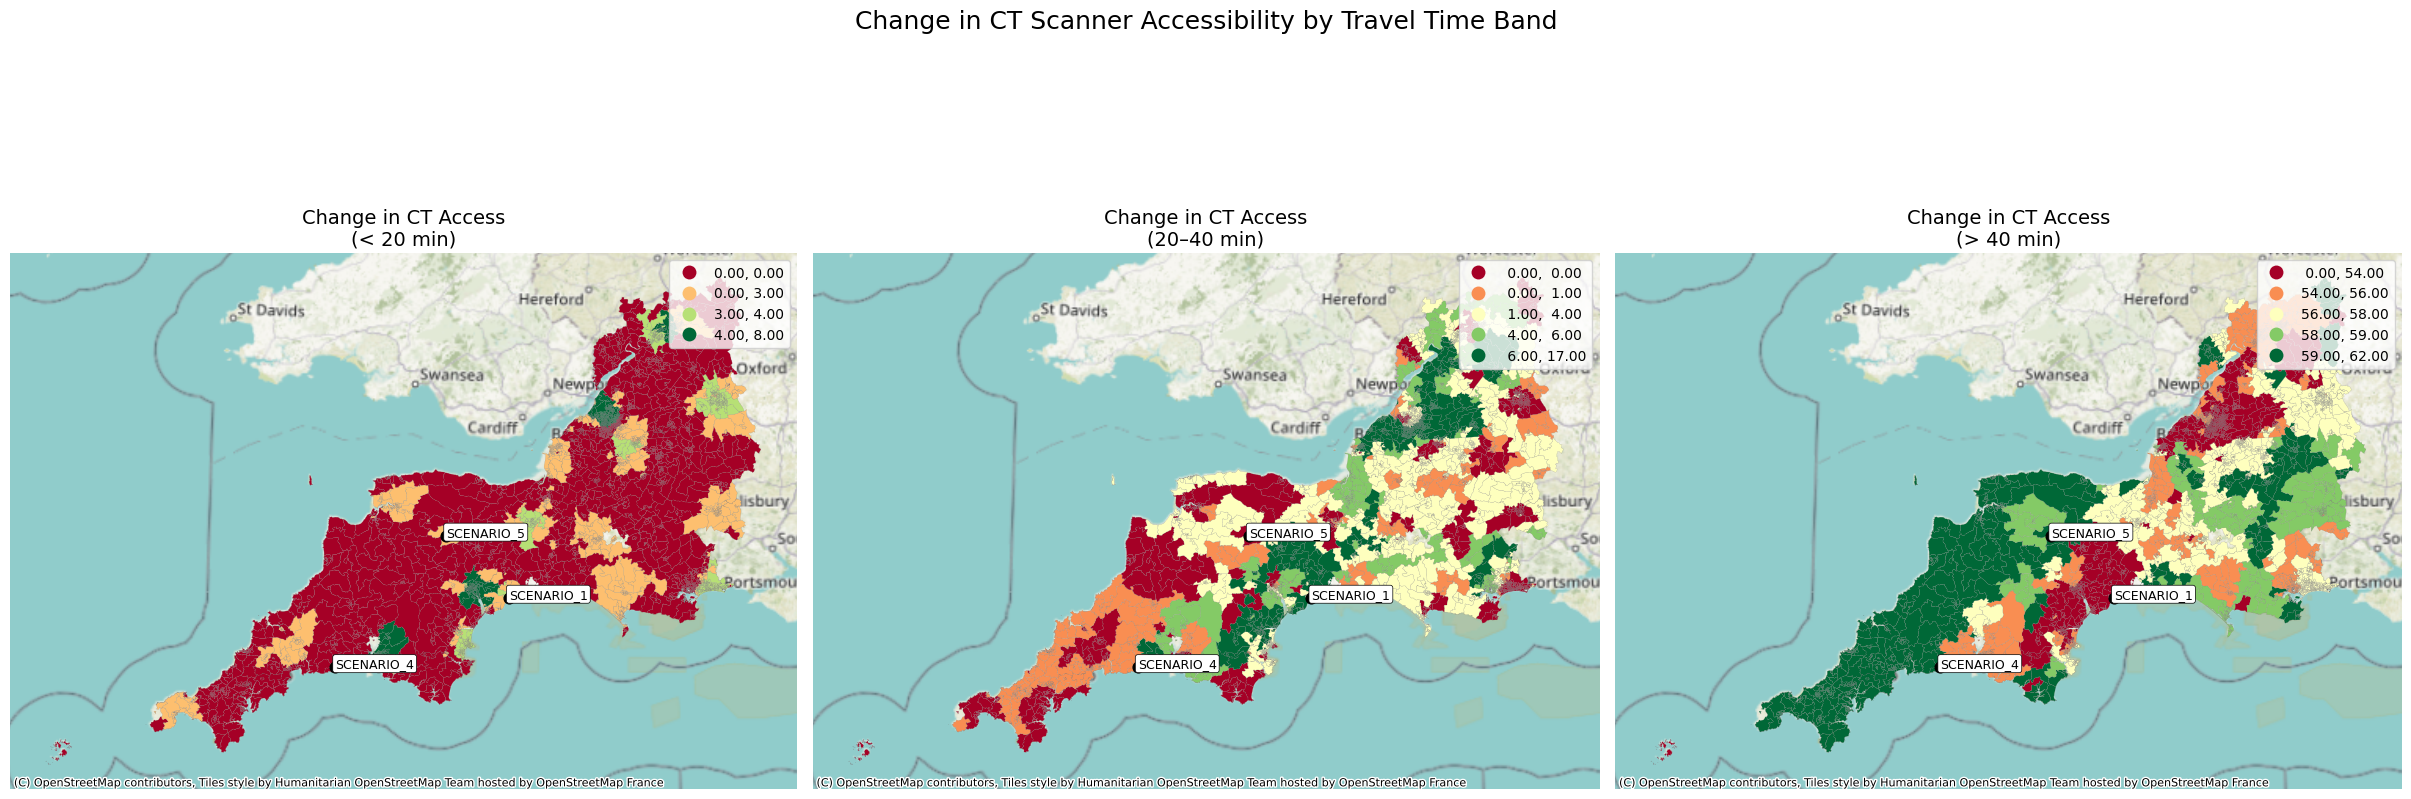

In [32]:
# ----------------------------------------------------------
# Step 5 – Visualise Accessibility Change with Scenario Sites
# ----------------------------------------------------------

# Define delta columns and titles
delta_columns = [
    'ct_access_car_lt_20_delta',
    'ct_access_car_20_40_delta',
    'ct_access_car_gt_40_delta'
]

titles = [
    'Change in CT Access\n(< 20 min)',
    'Change in CT Access\n(20–40 min)',
    'Change in CT Access\n(> 40 min)'
]

# Setup 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(24, 10), constrained_layout=True)

for i, (col, title) in enumerate(zip(delta_columns, titles)):
    gdf_lsoa.plot(
        column=col,
        cmap='RdYlGn',
        scheme='quantiles',
        k=5,
        legend=True,
        ax=axes[i],
        edgecolor='grey',
        linewidth=0.1,
        missing_kwds={"color": "lightgrey"}
    )
    ctx.add_basemap(axes[i], crs=gdf_lsoa.crs)

    # Plot scenario sites
    gdf_new_sites[gdf_new_sites["site_id"].isin(["SCENARIO_1", "SCENARIO_4", "SCENARIO_5"])]\
        .plot(ax=axes[i], color="black", markersize=60, label="New Scanner Site")

    # Add arrows pointing to each site
    for _, row in gdf_new_sites.iterrows():
        if row["site_id"] in ["SCENARIO_1", "SCENARIO_4", "SCENARIO_5"]:
            x, y = row.geometry.x, row.geometry.y
            axes[i].annotate(
                row["site_id"],
                xy=(x, y),
                xytext=(x + 0.2, y + 0.2),
                textcoords="data",
                arrowprops=dict(facecolor="black", arrowstyle="->", lw=1),
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.5)
            )

    axes[i].set_title(title, fontsize=14)
    axes[i].axis('off')

fig.suptitle("Change in CT Scanner Accessibility by Travel Time Band", fontsize=18)
plt.show()
